# MNIST Neuron Ablation Demo

Identify neurons highly activated for digit '7', then ablate them

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

    def get_layer_activations(self, x, layer_name):
        x = x.view(-1, 784)
        activations = {}

        x = F.relu(self.fc1(x))
        if layer_name == 'fc1':
            activations['fc1'] = x.clone()

        x = F.relu(self.fc2(x))
        if layer_name == 'fc2':
            activations['fc2'] = x.clone()

        x = F.relu(self.fc3(x))
        if layer_name == 'fc3':
            activations['fc3'] = x.clone()

        x = self.fc4(x)
        if layer_name == 'fc4':
            activations['fc4'] = x.clone()

        return activations.get(layer_name, None)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.ToTensor()
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [ ]:
# model training
def train_model(model, train_loader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

In [ ]:
# model testing
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return 100 * correct / total

In [ ]:
# find digit specific neurons
def find_digit_specific_neurons(model, data_loader, target_digit, layer_name='fc2', top_k=10):
    model.eval()
    digit_activations = []

    with torch.no_grad():
        for data, target in data_loader:
            digit_mask = (target == target_digit)
            if digit_mask.sum() > 0:
                digit_data = data[digit_mask]
                activations = model.get_layer_activations(digit_data, layer_name)
                digit_activations.append(activations)

    if digit_activations:
        all_activations = torch.cat(digit_activations, dim=0)
        mean_activations = all_activations.mean(dim=0)
        top_neurons = torch.topk(mean_activations, top_k).indices
        return top_neurons.tolist()
    return []

In [ ]:
# ablate selected neurons
def ablate_neurons(model, layer_name, neuron_indices):
    ablated_model = type(model)()
    ablated_model.load_state_dict(model.state_dict())

    class AblationHook:
        def __init__(self, neuron_indices):
            self.neuron_indices = neuron_indices

        def __call__(self, module, input, output):
            for idx in self.neuron_indices:
                if idx < output.size(1):
                    output[:, idx] = 0
            return output

    if layer_name == 'fc1':
        ablated_model.fc1.register_forward_hook(AblationHook(neuron_indices))
    elif layer_name == 'fc2':
        ablated_model.fc2.register_forward_hook(AblationHook(neuron_indices))
    elif layer_name == 'fc3':
        ablated_model.fc3.register_forward_hook(AblationHook(neuron_indices))

    return ablated_model

In [ ]:
# digit accuracy
def test_digit_specific_accuracy(model, test_loader, target_digit):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            digit_mask = (target == target_digit)
            if digit_mask.sum() > 0:
                digit_data = data[digit_mask]
                digit_target = target[digit_mask]
                output = model(digit_data)
                _, predicted = torch.max(output.data, 1)
                total += digit_target.size(0)
                correct += (predicted == digit_target).sum().item()

    return 100 * correct / total if total > 0 else 0

## Run ablation

In [ ]:
def run_ablation_study():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    model = MNISTNet()
    train_model(model, train_loader, epochs=10)

    original_accuracy = test_model(model, test_loader)

    target_digit = 7
    important_neurons = find_digit_specific_neurons(model, train_loader, target_digit, layer_name='fc2', top_k=5)

    ablated_model = ablate_neurons(model, 'fc2', important_neurons)

    original_digit_accuracy = test_digit_specific_accuracy(model, test_loader, target_digit)
    ablated_digit_accuracy = test_digit_specific_accuracy(ablated_model, test_loader, target_digit)
    ablated_overall_accuracy = test_model(ablated_model, test_loader)

    results = {
        'original_overall_accuracy': original_accuracy,
        'original_digit_accuracy': original_digit_accuracy,
        'ablated_digit_accuracy': ablated_digit_accuracy,
        'ablated_overall_accuracy': ablated_overall_accuracy,
        'important_neurons': important_neurons,
        'target_digit': target_digit
    }

    return results, model, ablated_model


In [ ]:
# visualize ablation
def visualize_ablation_effects(results):
    target_digit = results['target_digit']

    categories = ['Overall\nAccuracy', f'Digit {target_digit}\nAccuracy']
    original_scores = [results['original_overall_accuracy'], results['original_digit_accuracy']]
    ablated_scores = [results['ablated_overall_accuracy'], results['ablated_digit_accuracy']]

    x = np.arange(len(categories))
    width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, original_scores, width, label='Original Model', alpha=0.8)
    plt.bar(x + width/2, ablated_scores, width, label='Ablated Model', alpha=0.8)

    plt.xlabel('Test Category')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Neuron Ablation Effect on Digit {target_digit} Recognition')
    plt.xticks(x, categories)
    plt.legend()
    plt.ylim(0, 100)

    for i, (orig, abl) in enumerate(zip(original_scores, ablated_scores)):
        plt.text(i - width/2, orig + 1, f'{orig:.1f}%', ha='center', va='bottom')
        plt.text(i + width/2, abl + 1, f'{abl:.1f}%', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

Neuron Ablation Study Results:
Target digit: 7
Important neurons ablated: [74, 78, 46, 90, 15]
Original overall accuracy: 97.85%
Original digit 7 accuracy: 97.28%
Ablated overall accuracy: 97.26%
Ablated digit 7 accuracy: 91.05%
Performance drop for digit 7: 6.23%


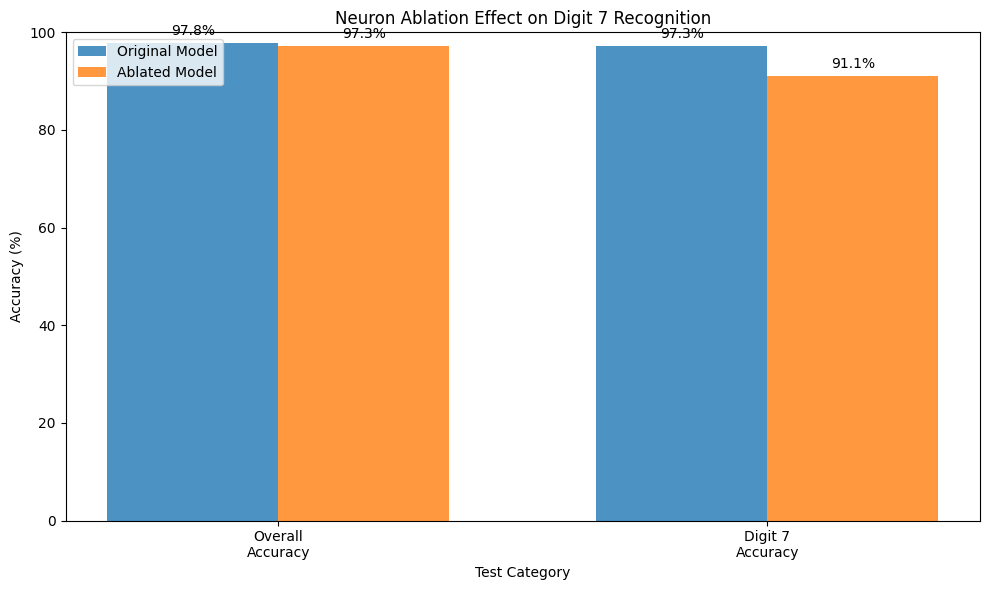

In [ ]:
if __name__ == "__main__":
    results, original_model, ablated_model = run_ablation_study()

    print("Neuron Ablation Study Results:")
    print(f"Target digit: {results['target_digit']}")
    print(f"Important neurons ablated: {results['important_neurons']}")
    print(f"Original overall accuracy: {results['original_overall_accuracy']:.2f}%")
    print(f"Original digit {results['target_digit']} accuracy: {results['original_digit_accuracy']:.2f}%")
    print(f"Ablated overall accuracy: {results['ablated_overall_accuracy']:.2f}%")
    print(f"Ablated digit {results['target_digit']} accuracy: {results['ablated_digit_accuracy']:.2f}%")
    print(f"Performance drop for digit {results['target_digit']}: {results['original_digit_accuracy'] - results['ablated_digit_accuracy']:.2f}%")

    visualize_ablation_effects(results)